## Analyze a PS-VAE model
Because the PS-VAEs currently require significant computation time (generally ~5 hours on a GPU) the data downloaded in the previous notebook also contains already trained PS-VAEs, which we will analyze here.

There are a variety of files that are automatically saved during the fitting of a PS-VAE, which can be used for later analyses such as those below. Some of these files (many of which are common to all BehaveNet models, not just the PS-VAE):
* `best_val_model.pt`: the best PS-VAE (not necessarily from the final training epoch) as determined by computing the loss on validation data
* `meta_tags.csv`: hyperparameters associated with data, computational resources, and model
* `metrics.csv`: metrics computed on dataset as a function of epochs; the default is that metrics are computed on training and validation data every epoch (and reported as a mean over all batches) while metrics are computed on test data only at the end of training using the best model (and reported per batch).
* `[lab_id]_[expt_id]_[animal_id]_[session_id]_latents.pkl`: list of np.ndarrays of PS-VAE latents (both supervised and unsupervised) computed using the best model
* `session_info.csv`: sessions used to fit the model

To fit your own PS-VAEs, see additional documentation [here](https://behavenet.readthedocs.io/en/latest/source/user_guide.html).

<br>

### Contents
* [Plot validation losses as a function of epochs](#Plot-losses-as-a-function-of-epochs)
* [Plot label reconstructions](#Plot-label-reconstructions)
* [Plot latent traversals](#Plot-latent-traversals)
* [Make latent traversal movie](#Make-latent-traversal-movie)
* [Make frame reconstruction movie](#Make-reconstruction-movies)

In [1]:
import os

from behavenet import get_user_dir
from behavenet.plotting.cond_ae_utils import plot_psvae_training_curves
from behavenet.plotting.cond_ae_utils import plot_label_reconstructions
from behavenet.plotting.cond_ae_utils import plot_latent_traversals
from behavenet.plotting.cond_ae_utils import make_latent_traversal_movie

dataset = 'ibl'
save_outputs = True  # true to save figures/movies to user's figure directory
file_ext = 'pdf'  # figure format ('png' | 'jpeg' | 'pdf'); movies saved as mp4

In [2]:
# parameters common to all datasets
n_latents = 2  # number of unsupervised latents
train_frac = 0.5  # all models trained with 50% of training data to speed up fitting
experiment_name = 'demo-run'  # test-tube exp name

# set dataset-specific parameters
if dataset == 'ibl':
    
    lab = 'ibl'
    expt = 'angelakilab'
    animal = 'IBL-T4'
    session = '2019-04-23-001'
    n_labels = 4
    label_names = ['L paw (x)', 'R paw (x)', 'L paw (y)', 'R paw (y)']

    # define "best" model
    best_alpha = 1000
    best_beta = 5
    best_gamma = 500
    best_rng = 0

    # label reconstructions
    label_recon_trials= [229, 289, 419]  # good validation trials; also used for frame recon
    xtick_locs= [0, 30, 60, 90]
    frame_rate= 60
    scale= 0.4
        
    # latent traversal params
    label_min_p = 35  # lower bound of label traversals
    label_max_p = 85  # upper bound of label traversals
    ch = 0  # video channel to display
    n_frames_zs = 4  # n frames for supervised static traversals
    n_frames_zu = 4  # n frames for unsupervised static traversals
    label_idxs = [1, 0]  # horizontally move left/right paws
    crop_type = None  # no image cropping
    crop_kwargs = None  # no image cropping
    # select base frames for traversals
    trial_idxs = [11, 4, 0, None, None, None, None]  # trial index wrt to all test trials
    trials = [None, None, None, 169, 129, 429, 339]  # trial index wrt to *all* trials
    batch_idxs = [99, 99, 99, 16, 46, 11, 79]  # batch index within trial
    n_cols = 3  # width of traversal movie
    text_color = [1, 1, 1]  # text color for labels

## Plot losses as a function of epochs
The PS-VAE loss function contains many individual terms; this function plots each term separately (as well as the overall loss) to better understand model performance. Note that this function can also be used to plot training curves for multiple models simultaneously; see function documentation. 

Panel info (see paper for mathematical descriptions):
* loss=loss: total PS-VAE loss
* loss=loss_data_mse: mean square error on frames (actual loss function uses log-likelihood, a scaled version of the MSE)
* loss=label_r2: $R^2$ (per trial) of the label reconstructions (actual loss function uses log-likelihood)
* loss=loss_zs_kl: Kullback-Leibler (KL) divergence of supervised latents
* loss=loss_zu_mi: index-code mutual information of unuspervised latents
* loss=loss_zu_tc: total correlation of unuspervised latents
* loss=loss_zu_dwkl: dimension-wise KL of unuspervised latents
* loss=loss_AB_orth: orthogonality between supervised/unsupervised subspaces

[Back to contents](#Contents)

loading results with alpha=1000, beta=5, gamma=500 (version 0)


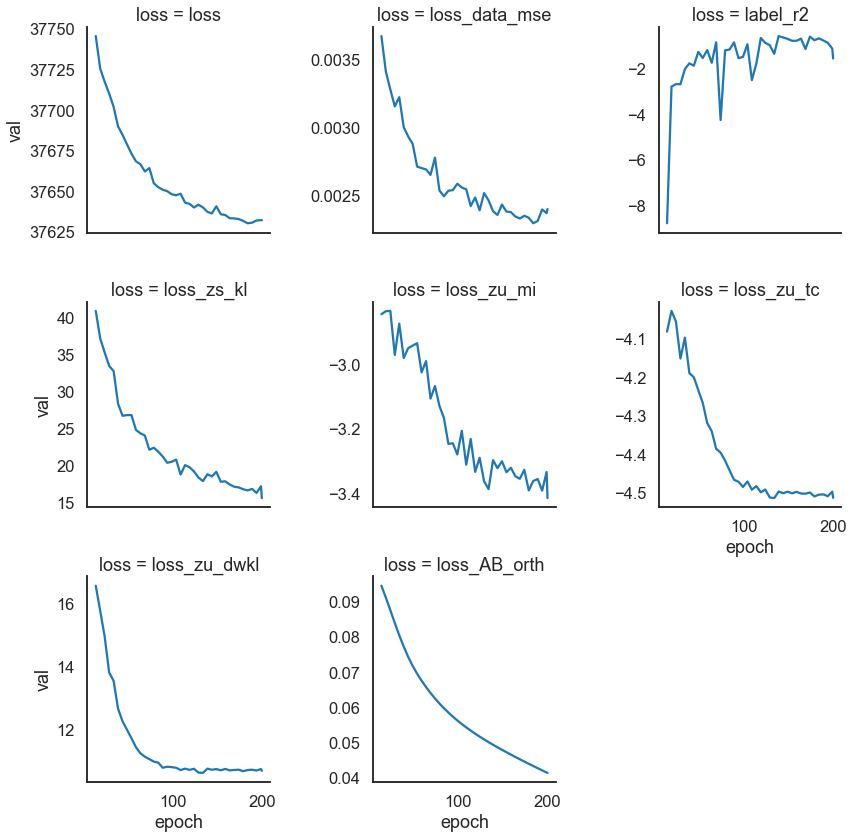

In [3]:
save_file = os.path.join(
    get_user_dir('fig'), lab, expt, animal, session, 'ps-vae', 'training_curves')

save_file_new = save_file + '_alpha={}_beta={}_gamma={}_rng={}_latents={}'.format(
    best_alpha, best_beta, best_gamma, best_rng, n_latents)
plot_psvae_training_curves(
    lab=lab, expt=expt, animal=animal, session=session, alphas=[best_alpha], 
    betas=[best_beta], gammas=[best_gamma], n_ae_latents=[n_latents], 
    rng_seeds_model=[0], experiment_name=experiment_name,
    n_labels=n_labels, train_frac=train_frac,
    save_file=save_file_new, format=file_ext)

## Plot label reconstructions
Plot the original labels and their reconstructions from the supervised subspace of the PS-VAE.

[Back to contents](#Contents)

Loading model defined in /media/mattw/data/ps-vae_demo_head-fixed/results/ibl/angelakilab/IBL-T4/2019-04-23-001/ps-vae/conv/06_latents/demo-run/version_0/meta_tags.pkl
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
ibl_angelakilab_IBL-T4_2019-04-23-001
    signals: ['images', 'labels']
    transforms: OrderedDict([('images', None), ('labels', None)])
    paths: OrderedDict([('images', '/media/mattw/data/ps-vae_demo_head-fixed/data/ibl/angelakilab/IBL-T4/2019-04-23-001/data.hdf5'), ('labels', '/media/mattw/data/ps-vae_demo_head-fixed/data/ibl/angelakilab/IBL-T4/2019-04-23-001/data.hdf5')])

alpha: 1000
beta: 5
gamma: 500
model seed: 0


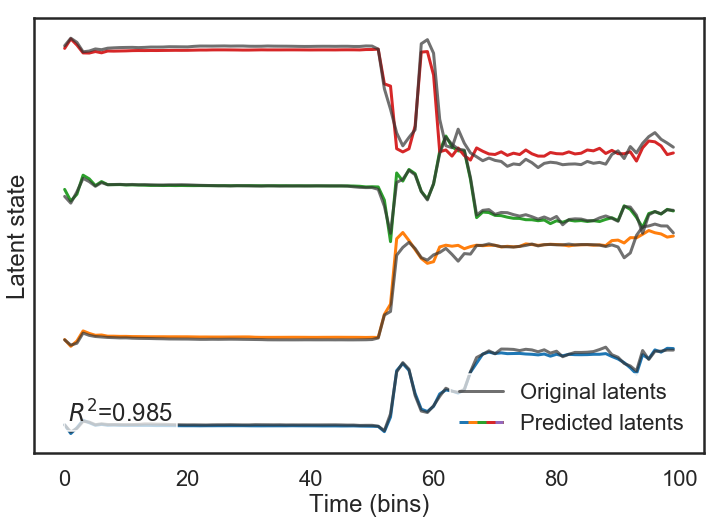

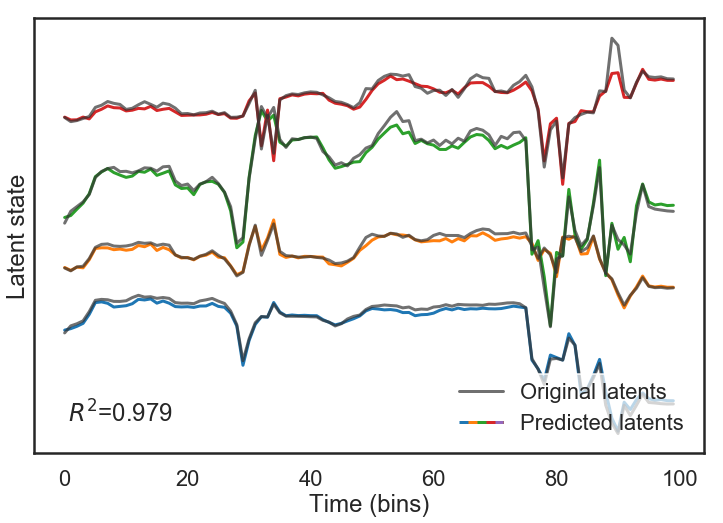

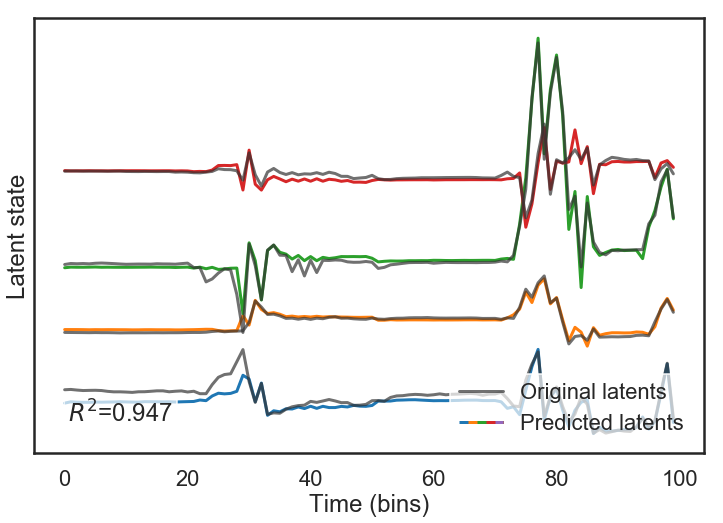

In [4]:
save_file = os.path.join(
    get_user_dir('fig'), lab, expt, animal, session, 'ps-vae', 'label_recon')

plot_label_reconstructions(
    lab=lab, expt=expt, animal=animal, session=session, n_ae_latents=n_latents, 
    experiment_name=experiment_name,
    n_labels=n_labels, trials=label_recon_trials, version=None,
    alpha=best_alpha, beta=best_beta, gamma=best_gamma, rng_seed_model=best_rng, 
    train_frac=train_frac, save_file=save_file, format=file_ext)

## Plot latent traversals
Latent traversals provide a qualitative way to assess the quality of the learned PS-VAE representation. We generate these traversals by changing the latent representation one dimension at a time and visually compare the outputs. If the representation is sufficiently interpretable we should be able to easily assign semantic meaning to each latent dimension.

[Back to contents](#Contents)

Loading model defined in /media/mattw/data/ps-vae_demo_head-fixed/results/ibl/angelakilab/IBL-T4/2019-04-23-001/ps-vae/conv/06_latents/demo-run/version_0/meta_tags.pkl
using data from following sessions:
/media/mattw/data/ps-vae_demo_head-fixed/results/ibl/angelakilab/IBL-T4/2019-04-23-001
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
ibl_angelakilab_IBL-T4_2019-04-23-001
    signals: ['labels']
    transforms: OrderedDict([('labels', None)])
    paths: OrderedDict([('labels', '/media/mattw/data/ps-vae_demo_head-fixed/data/ibl/angelakilab/IBL-T4/2019-04-23-001/data.hdf5')])

using data from following sessions:
/media/mattw/data/ps-vae_demo_head-fixed/results/ibl/angelakilab/IBL-T4/2019-04-23-001
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
ibl_angelakilab_IBL-T4_2019-04-23-001
    signals: ['labels_sc']
    transforms: OrderedDict([('labels_sc', None)])
    paths: OrderedDict([('labels_sc', '/media/mattw/d

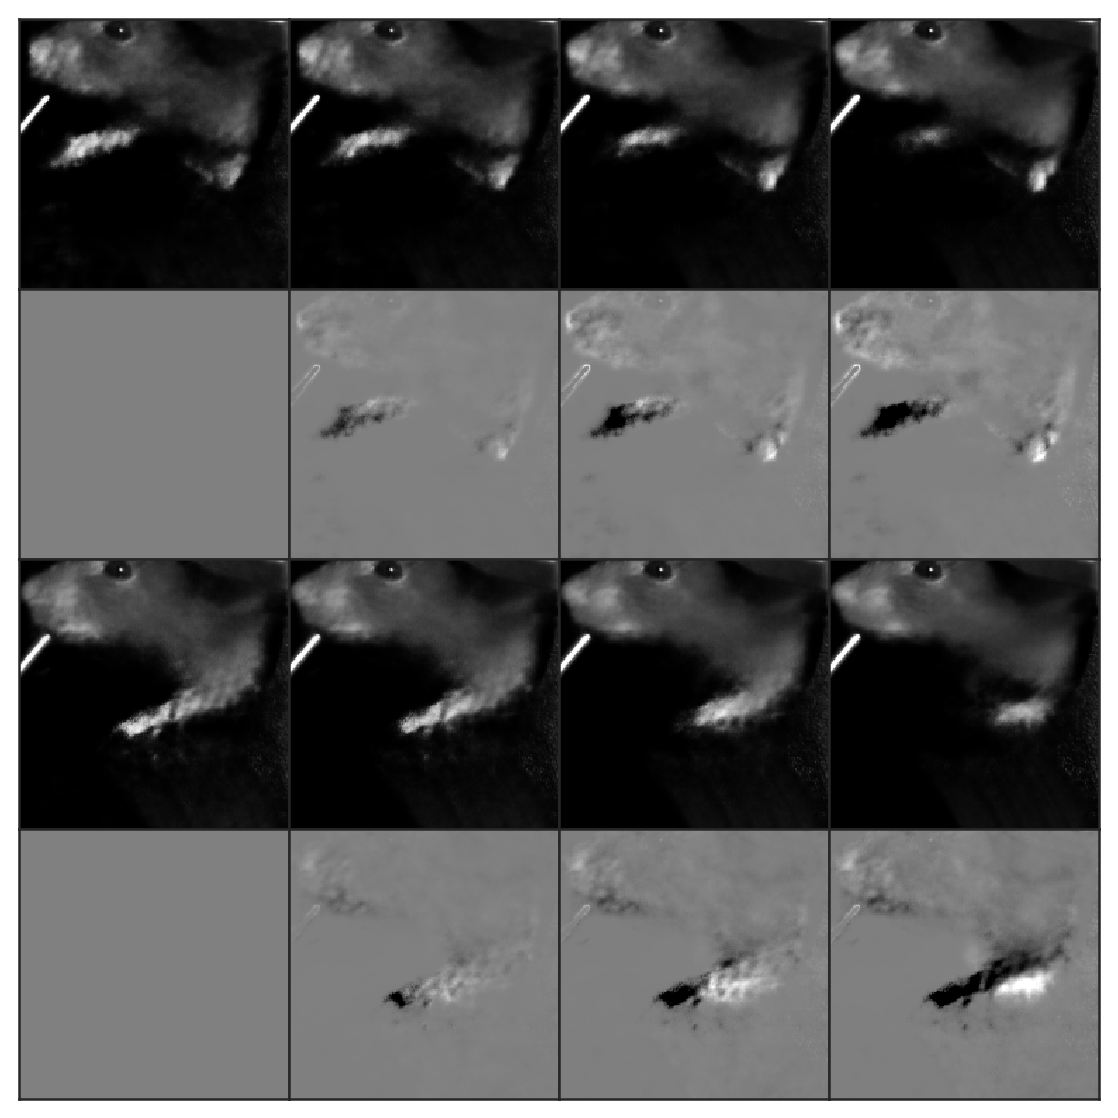

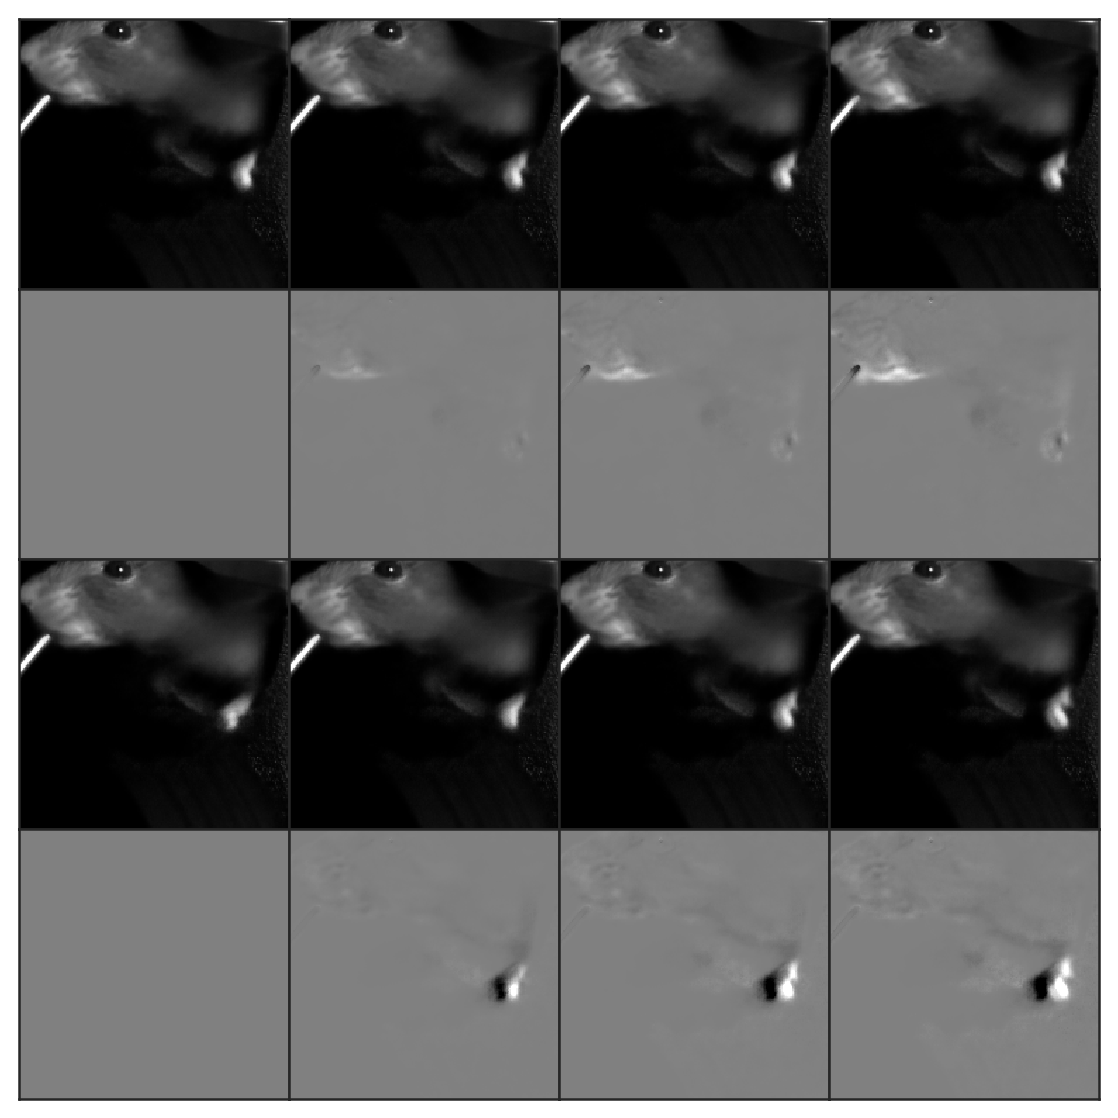

In [5]:
n_latents = 2

# for trial, trial_idx, batch_idx in zip(trials, trial_idxs, batch_idxs):
# just plot traversals for single base frame
trial = trials[0]
trial_idx = trial_idxs[0]
batch_idx = batch_idxs[0]

if trial is not None:
    trial_str = 'trial-%i-%i' % (trial, batch_idx)
else:
    trial_str = 'trial-idx-%i-%i' % (trial_idx, batch_idx)

save_file = os.path.join(
    get_user_dir('fig'), lab, expt, animal, session, 'ps-vae', 
    'traversals_alpha={}_beta={}_gamma={}_rng={}_latents={}_{}'.format(
    best_alpha, best_beta, best_gamma, best_rng, n_latents, trial_str))

plot_latent_traversals(
    lab=lab, expt=expt, animal=animal, session=session, model_class='ps-vae', 
    alpha=best_alpha, beta=best_beta, gamma=best_gamma, n_ae_latents=2, 
    rng_seed_model=best_rng, experiment_name=experiment_name, 
    n_labels=n_labels, label_idxs=label_idxs,
    label_min_p=label_min_p, label_max_p=label_max_p, channel=ch, 
    n_frames_zs=n_frames_zs, n_frames_zu=n_frames_zu, trial_idx=trial_idx, 
    trial=trial, batch_idx=batch_idx, crop_type=crop_type, crop_kwargs=crop_kwargs,
    train_frac=train_frac, save_file=save_file, format='png')

## Make latent traversal movie
A dynamic version of the traversals above; these typically provide a richer look at the traversal results.

[Back to contents](#Contents)

Loading model defined in /media/mattw/data/ps-vae_demo_head-fixed/results/ibl/angelakilab/IBL-T4/2019-04-23-001/ps-vae/conv/06_latents/demo-run/version_0/meta_tags.pkl
using data from following sessions:
/media/mattw/data/ps-vae_demo_head-fixed/results/ibl/angelakilab/IBL-T4/2019-04-23-001
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
ibl_angelakilab_IBL-T4_2019-04-23-001
    signals: ['labels']
    transforms: OrderedDict([('labels', None)])
    paths: OrderedDict([('labels', '/media/mattw/data/ps-vae_demo_head-fixed/data/ibl/angelakilab/IBL-T4/2019-04-23-001/data.hdf5')])

saving video to /media/mattw/data/ps-vae_demo_head-fixed/figs/ibl/angelakilab/IBL-T4/2019-04-23-001/ps-vae/traversals_alpha=1000_beta=5_gamma=500_rng=0_latents=2.mp4...done


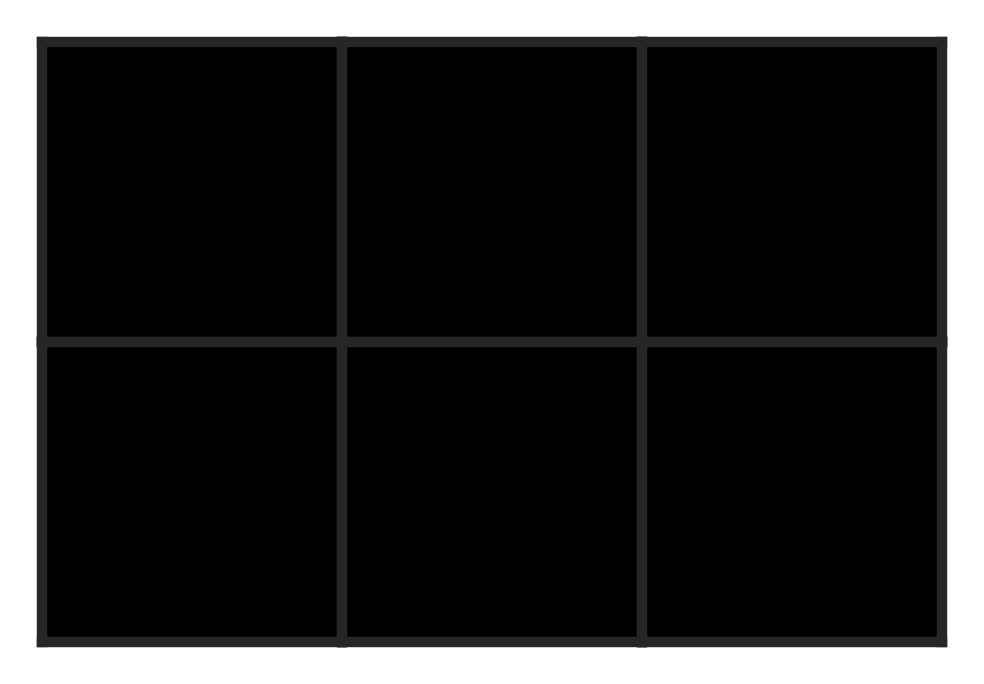

In [6]:
n_frames = 10  # number of sample frames per dimension
model_class = 'ps-vae'  # 'sss-vae' | 'vae'

# NOTE: below I hand label each dimension; semantic labels for unsupervised dims are chosen
# by looking at the latent traversals above, and are indicated with quotes to distinguish
# them from the supervised dims

if dataset == 'ibl':
    if model_class == 'ps-vae':
        panel_titles = [
            'L paw (x)', 'R paw (x)', 'L paw (y)', 'R paw (y)', '"Jaw"', '"L paw config"']
        order_idxs = [0, 1, 4, 2, 3, 5]  # reorder nicely
    elif model_class == 'vae':
        panel_titles = [
            'Latent 0', 'Latent 1', 'Latent 2', 'Latent 3', 'Latent 4', 'Latent 5']
        order_idxs = [0, 1, 2, 3, 4, 5]
    else:
        raise NotImplementedError

elif dataset == 'dipoppa':
    crop_kwargs = None
    if model_class == 'ps-vae':
        panel_titles = [
            'Pupil area', 'Pupil (y)', 'Pupil (x)', '"Whisker pad"', '"Eyelid"']
        order_idxs = [2, 1, 0, 3, 4]
    elif model_class == 'vae':
        panel_titles = [
            'Latent 0', 'Latent 1', 'Latent 2', 'Latent 3', 'Latent 4']
        order_idxs = [0, 1, 2, 3, 4]
    else:
        raise NotImplementedError

elif dataset == 'musall-wpaw':
#     crop_kwargs_ = None
#     show_markers = True       
    if model_class == 'sss-vae':
        panel_titles = [
            'Lever', 'R spout', 'L spout', 'R paw (y)', 'R paw (x)', '"Chest"', 
            '"Jaw"']
        order_idxs = [1, 2, 3, 4, 0, 5, 6, 7]
    elif model_class == 'vae':
        panel_titles = [
            'Latent 0', 'Latent 1', 'Latent 2', 'Latent 3', 'Latent 4', 'Latent 5', 
            'Latent 6']
        order_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
    else:
        raise NotImplementedError

else:
    raise NotImplementedError

save_file = os.path.join(
    get_user_dir('fig'), lab, expt, animal, session, model_class, 
    'traversals_alpha={}_beta={}_gamma={}_rng={}_latents={}'.format(
    best_alpha, best_beta, best_gamma, best_rng, n_latents))

make_latent_traversal_movie(
    lab=lab, expt=expt, animal=animal, session=session, model_class=model_class, 
    alpha=best_alpha, beta=best_beta, gamma=best_gamma, n_ae_latents=n_latents, 
    rng_seed_model=best_rng, experiment_name=experiment_name, 
    n_labels=n_labels, trial_idxs=trial_idxs, batch_idxs=batch_idxs, trials=trials, 
    panel_titles=panel_titles, label_min_p=label_min_p, 
    label_max_p=label_max_p, channel=ch, n_frames=n_frames, crop_kwargs=crop_kwargs, 
    n_cols=n_cols, movie_kwargs={'text_color': text_color}, order_idxs=order_idxs,
    train_frac=train_frac, save_file=save_file)

## Make reconstruction movies
Compare original frames to VAE and PS-VAE reconstructions.

[Back to contents](#Contents)

#### helper function

In [7]:
import numpy as np

from behavenet.plotting.ae_utils import make_reconstruction_movie
from behavenet.plotting.cond_ae_utils import get_model_input
from behavenet.fitting.eval import get_reconstruction
from behavenet.fitting.utils import get_best_model_and_data, get_lab_example
from behavenet.plotting import concat, save_movie

def make_reconstruction_movie_wrapper(
        hparams, save_file, model_info, trial_idxs=None, trials=None, sess_idx=0, 
        max_frames=400, frame_rate=15, layout_pattern=None):
    """Produce movie with original video and reconstructed videos.

    This is a high-level function that loads the model described in the hparams dictionary 
    and produces the necessary predicted video frames.

    Parameters
    ----------
    hparams : :obj:`dict`
        needs to contain enough information to specify an autoencoder
    save_file : :obj:`str`
        full save file (path and filename)
    model_info : :obj:`list`
        each entry is a dict that contains model-specific parameters; must include
        'title', 'model_class'
    trial_idxs : :obj:`list`, optional
        list of test trials to construct videos from; each element is index into  
        test trials only; one of `trial_idxs` or `trials` must be 
        specified; `trials` takes precedence over `trial_idxs`
    trials : :obj:`list`, optional
        list of test trials to construct videos from; each element is index into all 
        possible trials (train, val, test); one of `trials` or `trial_idxs` must be 
        specified; `trials` takes precedence over `trial_idxs`
    sess_idx : :obj:`int`, optional
        session index into data generator
    max_frames : :obj:`int`, optional
        maximum number of frames to animate from a trial
    frame_rate : :obj:`float`, optional
        frame rate of saved movie
    layout_pattern : :obj:`array-like`, optional
        boolean entries specify which panels are used to display frames
        
    """

    n_labels = hparams['n_labels']
    n_latents = hparams['n_ae_latents']
    expt_name = hparams['experiment_name']

    # set up models to fit
    titles = ['Original']
    for model in model_info:
        titles.append(model['title'])
        
    # insert original video at front
    model_info.insert(0, {'model_class': None})

    ims_recon = [[] for _ in titles]
    latents = [[] for _ in titles]
    
    if trial_idxs is None:
        trial_idxs = [None] * len(trials)
    if trials is None:
        trials = [None] * len(trial_idxs)

    for i, model in enumerate(model_info):

        if i == 0:
            continue
            
        # further specify model
        version = model.get('version', 'best')
        hparams['experiment_name'] = model.get('experiment_name', expt_name)
        hparams['model_class'] = model['model_class']
        model_ae, data_generator = get_best_model_and_data(hparams, None, version=version)

        # get images
        for trial_idx, trial in zip(trial_idxs, trials):

            # get model inputs
            ims_orig_pt, ims_orig_np, _, labels_pt, _, labels_2d_pt, _ = get_model_input(
                data_generator, hparams, model_ae, trial_idx=trial_idx, trial=trial,
                sess_idx=sess_idx, max_frames=max_frames, compute_latents=False, 
                compute_2d_labels=False)
            
            # get model outputs
            ims_recon_tmp, latents_tmp = get_reconstruction(
                model_ae, ims_orig_pt, labels=labels_pt, labels_2d=labels_2d_pt,
                return_latents=True)
            ims_recon[i].append(ims_recon_tmp)
            latents[i].append(latents_tmp)
                
            # add a couple black frames to separate trials
            final_trial = True
            if (trial_idx is not None and (trial_idx != trial_idxs[-1])) or \
                    (trial is not None and (trial != trials[-1])):
                final_trial = False

            n_buffer = 5
            if not final_trial:
                _, n, y_p, x_p = ims_recon[i][-1].shape
                ims_recon[i].append(np.zeros((n_buffer, n, y_p, x_p)))
                latents[i].append(np.nan * np.zeros((n_buffer, n_latents)))

            if i == 1:  # deal with original frames only once
                ims_recon[0].append(ims_orig_np)
                latents[0].append([])
                # add a couple black frames to separate trials
                if not final_trial:
                    _, n, y_p, x_p = ims_recon[0][-1].shape
                    ims_recon[0].append(np.zeros((n_buffer, n, y_p, x_p)))
        
    for i, (ims, zs) in enumerate(zip(ims_recon, latents)):
        ims_recon[i] = np.concatenate(ims, axis=0)
        latents[i] = np.concatenate(zs, axis=0)
    
    if layout_pattern is None:
        if len(titles) < 4:
            n_rows, n_cols = 1, len(titles)
        elif len(titles) == 4:
            n_rows, n_cols = 2, 2
        elif len(titles) > 4:
            n_rows, n_cols = 2, 3
        else:
            raise ValueError('too many models')
    else:
        assert np.sum(layout_pattern) == len(ims_recon)
        n_rows, n_cols = layout_pattern.shape
        count = 0
        for pos_r in layout_pattern:
            for pos_c in pos_r:
                if not pos_c:
                    ims_recon.insert(count, [])
                    titles.insert(count, [])
                count += 1

    make_reconstruction_movie(
        ims=ims_recon, titles=titles, n_rows=n_rows, n_cols=n_cols, 
        save_file=save_file, frame_rate=frame_rate)

Loading model defined in /media/mattw/data/ps-vae_demo_head-fixed/results/ibl/angelakilab/IBL-T4/2019-04-23-001/ps-vae/conv/06_latents/demo-run/version_0/meta_tags.pkl
Loading model defined in /media/mattw/data/ps-vae_demo_head-fixed/results/ibl/angelakilab/IBL-T4/2019-04-23-001/vae/conv/06_latents/demo-run/version_0/meta_tags.pkl
saving video to /media/mattw/data/ps-vae_demo_head-fixed/figs/ibl/angelakilab/IBL-T4/2019-04-23-001/ps-vae/reconstructions_alpha=1000_beta=5_gamma=500_rng=0_latents=2.mp4...done


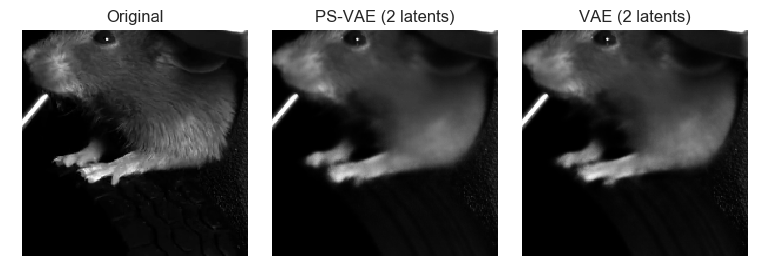

In [8]:
# set model info
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'n_labels': n_labels,
    'n_ae_latents': n_latents + n_labels,
    'experiment_name': None,
    'model_type': 'conv',
    'conditional_encoder': False,
}

# programmatically fill out other hparams options
get_lab_example(hparams, lab, expt)

# compare vae/ps-vae reconstructions
model_info = [
    {
        'model_class': 'ps-vae',
        'experiment_name': 'demo-run',
        'title': 'PS-VAE (%i latents)' % n_latents,
        'version': 0},
    {
        'model_class': 'vae',
        'experiment_name': 'demo-run',
        'title': 'VAE (%i latents)' % n_latents,
        'version': 0},
]

save_file = os.path.join(
    get_user_dir('fig'), lab, expt, animal, session, model_class, 
    'reconstructions_alpha={}_beta={}_gamma={}_rng={}_latents={}'.format(
    best_alpha, best_beta, best_gamma, best_rng, n_latents))

make_reconstruction_movie_wrapper(
    hparams, save_file=save_file, trial_idxs=None, trials=label_recon_trials, 
    model_info=model_info, frame_rate=15)